# Inference and Validation

- **inference**: Making predictions (from statistics)
- **overfitting**: Model performs too well on the training data and  aren't able to generalize to data that hasn't been seen before
- **validation** set: To measure model's performance on data not in the training set
- Avoid overfitting: 
    - early stopping
    - dropout
    - regularization

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=4)

In [2]:
## Reuse model from Part 4

from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

Performance measurement in validation set:
- Accuracy $\leftarrow$ Use in this Part
- Precision, Recall, F1 score
- top 5 error

In [3]:
model = Classifier()

images, labels = next(iter(testloader))
ps = torch.exp(model(images))
print(ps.shape)

torch.Size([64, 10])


`ps.topk`: return **k highest** values

In [4]:
top_p, top_class = ps.topk(1, dim=1)
print(top_class[:10,:])

tensor([[2],
        [2],
        [1],
        [2],
        [1],
        [1],
        [2],
        [1],
        [1],
        [2]])


In [5]:
print(top_p.shape)
print(top_class.shape)
print(labels.shape)

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64])


In [6]:
# <-same shape (64, 1) 
equals = top_class == labels.view(*top_class.shape) 
# <- torch.mean not implemented on torch.ByteTensor
accuracy = torch.mean(equals.type(torch.FloatTensor)) 
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 4.6875%


> Exercise: Implement the validation loop below and print out the total accuracy after the loop. 

In [7]:
model = Classifier()
critierion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [8]:
def accuracy(probs, labels):
    top_probs, top_classes = probs.topk(1, dim=1) # max of each row
    equals = top_classes == labels.view(*top_classes.shape)
    accuracy = torch.mean(equals.type(torch.FloatTensor))
    return accuracy

In [9]:
import numpy as np

In [10]:
epochs=30
steps=0
train_accs, val_accs = [], []

for epoch in range(epochs):
    running_loss = 0
    train_acc = []
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_probs = model(images)
        loss = critierion(log_probs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_acc.append(accuracy(log_probs, labels))
    else:
        train_loss = running_loss / len(trainloader)
        with torch.no_grad():
            val_acc = []
            for images, labels in testloader:
                log_probs = model(images)
                val_acc.append(accuracy(log_probs, labels))
            else:
                val_acc = np.mean(val_acc)
                train_acc = np.mean(train_acc)
                val_accs.append(val_acc)
                train_accs.append(train_acc)
                print(f"epoch #{epoch:02d}, train loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}")
                

epoch #00, train loss: 0.5185, train_acc: 0.8101, val_acc: 0.8410
epoch #01, train loss: 0.3742, train_acc: 0.8633, val_acc: 0.8508
epoch #02, train loss: 0.3387, train_acc: 0.8743, val_acc: 0.8717
epoch #03, train loss: 0.3158, train_acc: 0.8836, val_acc: 0.8606
epoch #04, train loss: 0.2938, train_acc: 0.8917, val_acc: 0.8763
epoch #05, train loss: 0.2770, train_acc: 0.8961, val_acc: 0.8771
epoch #06, train loss: 0.2624, train_acc: 0.9022, val_acc: 0.8752
epoch #07, train loss: 0.2509, train_acc: 0.9066, val_acc: 0.8827
epoch #08, train loss: 0.2410, train_acc: 0.9084, val_acc: 0.8813
epoch #09, train loss: 0.2299, train_acc: 0.9133, val_acc: 0.8800
epoch #10, train loss: 0.2186, train_acc: 0.9172, val_acc: 0.8878
epoch #11, train loss: 0.2079, train_acc: 0.9226, val_acc: 0.8896
epoch #12, train loss: 0.2016, train_acc: 0.9237, val_acc: 0.8846
epoch #13, train loss: 0.1934, train_acc: 0.9268, val_acc: 0.8817
epoch #14, train loss: 0.1883, train_acc: 0.9289, val_acc: 0.8852
epoch #15,

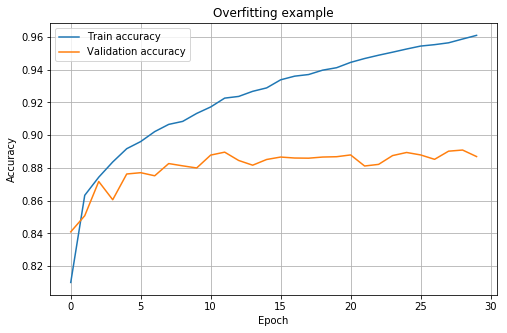

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), train_accs, label='Train accuracy')
plt.plot(range(epochs), val_accs, label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.title("Overfitting example")
plt.show()

### Overfitting

- Problems of model when failed to generalizing to data outside of the training set leading to validation accuracy decreasing
- Early stopping: Use the version of model when it has lowest validation loss, or highest validation accuracy
- `nn.Dropout`: 
    - Randomly drop input units $\rightarrow$ forces network to share information between weights
    - Using when training with `model.train()`, turn off dropout during validations with `model.eval()`

> **Exercise**: Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

In [12]:
from torch import nn, optim
import torch.nn.functional as F

class BetterClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [13]:
model = BetterClassifier()
critierion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

epochs=30
steps=0
train_accs, val_accs = [], []

for epoch in range(epochs):
    running_loss = 0
    train_acc = []
    model.train() # Turn on Dropout
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_probs = model(images)
        loss = critierion(log_probs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_acc.append(accuracy(log_probs, labels))
    else:
        train_loss = running_loss / len(trainloader)
        with torch.no_grad():
            model.eval() # Turn off Dropout
            val_acc = []
            for images, labels in testloader:
                log_probs = model(images)
                val_acc.append(accuracy(log_probs, labels))
            else:
                val_acc = np.mean(val_acc)
                train_acc = np.mean(train_acc)
                val_accs.append(val_acc)
                train_accs.append(train_acc)
                print(f"epoch #{epoch:02d}, train loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}")
                

epoch #00, train loss: 0.5955, train_acc: 0.7848, val_acc: 0.8327
epoch #01, train loss: 0.4318, train_acc: 0.8457, val_acc: 0.8545
epoch #02, train loss: 0.3956, train_acc: 0.8583, val_acc: 0.8592
epoch #03, train loss: 0.3692, train_acc: 0.8690, val_acc: 0.8661
epoch #04, train loss: 0.3519, train_acc: 0.8726, val_acc: 0.8636
epoch #05, train loss: 0.3390, train_acc: 0.8784, val_acc: 0.8682
epoch #06, train loss: 0.3314, train_acc: 0.8810, val_acc: 0.8690
epoch #07, train loss: 0.3179, train_acc: 0.8835, val_acc: 0.8759
epoch #08, train loss: 0.3088, train_acc: 0.8878, val_acc: 0.8776
epoch #09, train loss: 0.3057, train_acc: 0.8883, val_acc: 0.8769
epoch #10, train loss: 0.2941, train_acc: 0.8925, val_acc: 0.8822
epoch #11, train loss: 0.2906, train_acc: 0.8941, val_acc: 0.8787
epoch #12, train loss: 0.2852, train_acc: 0.8962, val_acc: 0.8833
epoch #13, train loss: 0.2806, train_acc: 0.8968, val_acc: 0.8803
epoch #14, train loss: 0.2734, train_acc: 0.9001, val_acc: 0.8872
epoch #15,

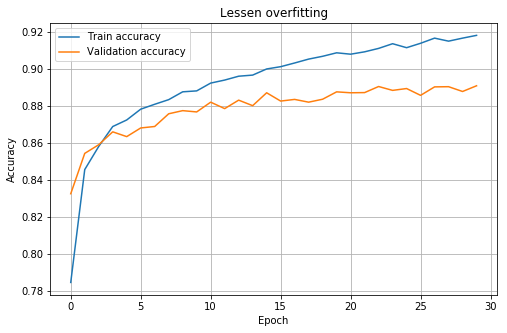

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), train_accs, label='Train accuracy')
plt.plot(range(epochs), val_accs, label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.title("Lessen overfitting")
plt.show()

### Inference

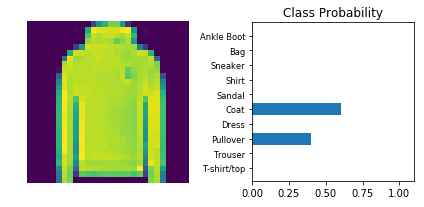

In [15]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')